# Exploration and concatenation of RTE data

Features of this notebook:

1. Explore two RTE datasets on electricity generation:

    1. Total installed wind and solar power, for each year (`parc-national-annuel-prod-eolien-solaire.csv`)
    2. [éCO2mix production & consumption data](https://www.rte-france.com/fr/eco2mix/eco2mix-telechargement) (yearly files, at 30 min timestep, except for the load which has 15 min timestep)

2. Export a self-contained file containing load, wind and solar capacity factor.

     * → for analysis of the complementarity between solar and wind production in [REn_Complementarity.ipynb](./REn_Complementarity.ipynb)

PH, march 2019

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset 1: Installed solar & wind power

In [5]:
df = pd.read_csv('data/parc-national-annuel-prod-eolien-solaire.csv', sep=';', index_col=0)
df.index.name = None
# shorter column names:
df.rename(columns={
    'Parc installé éolien (MW)':'P_wind',
    'Parc installé solaire (MW)': 'P_sol'}, inplace=True)
df.sort_index(inplace=True)
df.head(3)

,P_wind,P_sol
2001,94.0,0.0
2002,129.0,0.0
2003,219.0,0.0


In [6]:
df.tail(3)

,P_wind,P_sol
2016,11761.0,6773.0
2017,13550.0,7654.0
2018,15108.0,8527.0


Comparaison with RTE document [Panorama de l’électricité renouvelable](https://www.rte-france.com/fr/article/panorama-de-l-electricite-renouvelable), December 2018.

→ perfect match!

![Puissance éolienne raccordée, Panorama de l’Électricité Renouvelable en 2018](img/wind_inst_pow.png)
![Puissance solaire raccordée, Panorama de l’Électricité Renouvelable en 2018, p24](img/solar_inst_pow.png)

convert index to dates (2001 into date 2001-12-31).
* date parsing not good because it generates 2001-01-01
* easier to regenerate the index from scratch

In [7]:
df.index = pd.date_range(str(df.index[0]),periods=len(df), freq='Y')
df.tail(3)

,P_wind,P_sol
2016-12-31,11761.0,6773.0
2017-12-31,13550.0,7654.0
2018-12-31,15108.0,8527.0


### Plot the series

(NB, plot anchoring using the `DataFrame.plot` method is wrong)

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

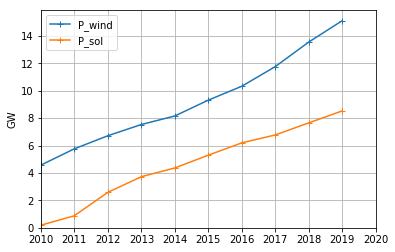

In [14]:
plt.plot(df.index, df/1e3, '-+')

plt.grid()
plt.legend(['P_wind', 'P_sol'])

plt.ylim(ymin=0)
plt.ylabel('GW')

# select only last decade
plt.xlim('2010','2020');

### Interpolation at 30 min timestep

(for later combination with production data)

In [17]:
inspow = df['2012':].resample('30T').interpolate()

In [18]:
inspow.head(3)

,P_wind,P_sol
2012-12-31 00:00:00,7536.000000,3727.000000
2012-12-31 00:30:00,7536.035445,3727.036473
2012-12-31 01:00:00,7536.070890,3727.072945


Small problem: last index is `2018-12-31 00:00:00`, and not `2018-12-31 23:30:00` as we may whish

In [19]:
inspow.tail(3)

,P_wind,P_sol
2018-12-30 23:00:00,15107.822146,8526.900342
2018-12-30 23:30:00,15107.911073,8526.950171
2018-12-31 00:00:00,15108.000000,8527.000000


Complete the last day of 2018:
1. concat dates with no data
2. fill NaNs with forward fill

In [20]:
last_day = pd.date_range('2018-12-31 00:30','2018-12-31 23:30',freq='30T')
last_day
last_day = pd.DataFrame(index=last_day)
last_day.tail(3)

""
2018-12-31 22:30:00
2018-12-31 23:00:00
2018-12-31 23:30:00


In [21]:
inspow = pd.concat([inspow, last_day], sort=False)
inspow.tail(3)

,P_wind,P_sol
2018-12-31 22:30:00,NaN,NaN
2018-12-31 23:00:00,NaN,NaN
2018-12-31 23:30:00,NaN,NaN


In [22]:
inspow = inspow.ffill()
inspow.tail(3)

,P_wind,P_sol
2018-12-31 22:30:00,15108.0,8527.0
2018-12-31 23:00:00,15108.0,8527.0
2018-12-31 23:30:00,15108.0,8527.0


In [24]:
len(inspow)

105216

Plot to check the result (a big slow because of the 105 kpts...)

/home/pierre/Programmes/bin/miniconda3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


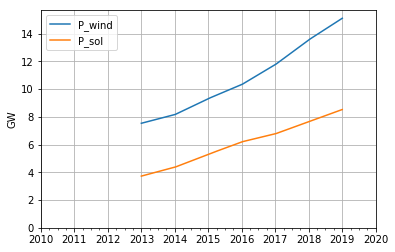

In [25]:
(inspow/1e3).plot()
plt.grid()
plt.xlim('2010','2020')
plt.ylabel('GW')

plt.ylim(ymin=0);

## Dataset 2: Production data

### First, read one file

In [1]:
columns_detailed = [
    'Consommation',
    'Fioul', 'Charbon', 'Gaz', 'Nucléaire',
    'Eolien', 'Solaire',
    'Hydraulique', 'Pompage', 'Bioénergies',
    'Ech. physiques',
    'Ech. comm. Angleterre', 'Ech. comm. Espagne',
    'Ech. comm. Italie', 'Ech. comm. Suisse',
    'Ech. comm. Allemagne-Belgique',
    'Fioul - TAC', 'Fioul - Cogén.', 'Fioul - Autres',
    'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG', 'Gaz - Autres',
    'Hydraulique - Fil de l?eau + éclusée',
    'Hydraulique - Lacs', 'Hydraulique - STEP turbinage',
    'Bioénergies - Déchets', 'Bioénergies - Biomasse', 'Bioénergies - Biogaz'
]

In [28]:
df = pd.read_csv('data/eCO2mix_RTE_Annuel-Definitif_2015.xls.xz', compression='xz', encoding='windows-1252',
                 sep='\t', skipfooter=2,engine='python',
                 index_col=False, parse_dates={'date':[2,3]})

In [29]:
df.head()

,date,Périmètre,Nature,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,...,Gaz - TAC,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz
0,2015-01-01 00:00:00,France,Données définitives,74494.0,72900,73700,269.0,2487.0,3476.0,57982.0,...,3.0,2056.0,1350.0,66.0,4810.0,3093.0,1418.0,560.0,181.0,197.0
1,2015-01-01 00:15:00,France,Données définitives,NaN,72250,73050,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 00:30:00,France,Données définitives,73481.0,71600,72400,319.0,2087.0,2691.0,57856.0,...,9.0,1926.0,670.0,86.0,4616.0,3561.0,1487.0,507.0,180.0,210.0
3,2015-01-01 00:45:00,France,Données définitives,NaN,70750,71500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 01:00:00,France,Données définitives,71506.0,69900,70600,320.0,1716.0,2436.0,57787.0,...,9.0,1919.0,422.0,86.0,4492.0,2805.0,1182.0,508.0,174.0,212.0


keep only data every 30 minutes

In [30]:
df = df.iloc[::2,:]
df.head()

,date,Périmètre,Nature,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,...,Gaz - TAC,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz
0,2015-01-01 00:00:00,France,Données définitives,74494.0,72900,73700,269.0,2487.0,3476.0,57982.0,...,3.0,2056.0,1350.0,66.0,4810.0,3093.0,1418.0,560.0,181.0,197.0
2,2015-01-01 00:30:00,France,Données définitives,73481.0,71600,72400,319.0,2087.0,2691.0,57856.0,...,9.0,1926.0,670.0,86.0,4616.0,3561.0,1487.0,507.0,180.0,210.0
4,2015-01-01 01:00:00,France,Données définitives,71506.0,69900,70600,320.0,1716.0,2436.0,57787.0,...,9.0,1919.0,422.0,86.0,4492.0,2805.0,1182.0,508.0,174.0,212.0
6,2015-01-01 01:30:00,France,Données définitives,71505.0,70600,71300,320.0,1589.0,2440.0,58156.0,...,10.0,1924.0,420.0,86.0,4369.0,2623.0,1301.0,512.0,180.0,212.0
8,2015-01-01 02:00:00,France,Données définitives,71134.0,70500,71100,320.0,1490.0,2441.0,57974.0,...,9.0,1927.0,419.0,86.0,4318.0,2670.0,1115.0,509.0,182.0,211.0


Use date as index

In [31]:
df.set_index('date', verify_integrity=True, inplace=True)
df.index.name = ''
df.head(3)

,Périmètre,Nature,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,Eolien,...,Gaz - TAC,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz
,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,France,Données définitives,74494.0,72900,73700,269.0,2487.0,3476.0,57982.0,1268.0,...,3.0,2056.0,1350.0,66.0,4810.0,3093.0,1418.0,560.0,181.0,197.0
2015-01-01 00:30:00,France,Données définitives,73481.0,71600,72400,319.0,2087.0,2691.0,57856.0,1343.0,...,9.0,1926.0,670.0,86.0,4616.0,3561.0,1487.0,507.0,180.0,210.0
2015-01-01 01:00:00,France,Données définitives,71506.0,69900,70600,320.0,1716.0,2436.0,57787.0,1356.0,...,9.0,1919.0,422.0,86.0,4492.0,2805.0,1182.0,508.0,174.0,212.0


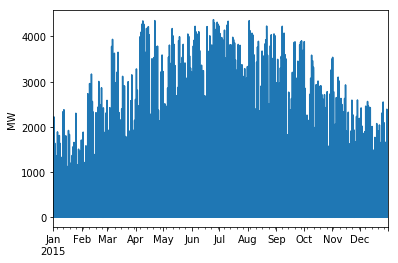

In [32]:
df.Solaire.plot()
plt.ylabel('MW');

### File reading automation

In [33]:
def read_eCO2mix(fname):
    """read eCO2mix data file. keep only wind, sun and load"""
    df = pd.read_csv(fname, compression='xz', encoding='windows-1252',
                 sep='\t', skipfooter=2,engine='python',
                 index_col=False, parse_dates={'date':[2,3]})
    # keep only data at 30 min step
    df = df.iloc[::2,:]
    # set date as the index
    df.set_index('date', verify_integrity=True, inplace=True)
    df.index.name = ''
    return df.loc[:,['Consommation','Eolien','Solaire']]

In [34]:
df = read_eCO2mix('data/eCO2mix_RTE_Annuel-Definitif_2015.xls.xz')

### Data concatenation

5 years (2014 - 2018)

In [35]:
!ls data/eCO2mix*.xz

data/eCO2mix_RTE_Annuel-Definitif_2014.xls.xz
data/eCO2mix_RTE_Annuel-Definitif_2015.xls.xz
data/eCO2mix_RTE_Annuel-Definitif_2016.xls.xz
data/eCO2mix_RTE_Annuel-Definitif_2017.xls.xz
data/eCO2mix_RTE_En-cours-Consolide.xls.xz


In [36]:
fname_list = [
    'data/eCO2mix_RTE_Annuel-Definitif_2014.xls.xz',
    'data/eCO2mix_RTE_Annuel-Definitif_2015.xls.xz',
    'data/eCO2mix_RTE_Annuel-Definitif_2016.xls.xz',
    'data/eCO2mix_RTE_Annuel-Definitif_2017.xls.xz',
    'data/eCO2mix_RTE_En-cours-Consolide.xls.xz'
]

In [37]:
fname = fname_list[0]
print(f'reading {fname}...')
df = read_eCO2mix(fname)

for fname in fname_list[1:]:
    print(f'reading {fname}...')
    df =  pd.concat([df, read_eCO2mix(fname)])

reading data/eCO2mix_RTE_Annuel-Definitif_2014.xls.xz...
reading data/eCO2mix_RTE_Annuel-Definitif_2015.xls.xz...
reading data/eCO2mix_RTE_Annuel-Definitif_2016.xls.xz...
reading data/eCO2mix_RTE_Annuel-Definitif_2017.xls.xz...
reading data/eCO2mix_RTE_En-cours-Consolide.xls.xz...


Check plot:

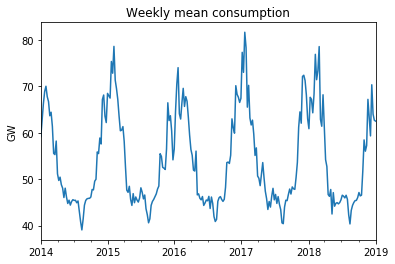

In [38]:
(df/1e3).resample('1W').mean().Consommation.plot()
plt.title('Weekly mean consumption')
plt.ylabel('GW');

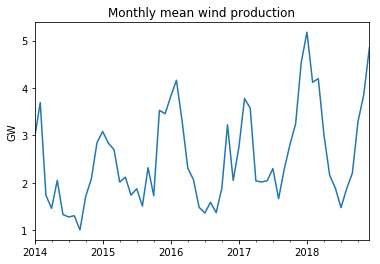

In [39]:
(df/1e3).resample('1M').mean().Eolien.plot()
plt.title('Monthly mean wind production')
plt.ylabel('GW');

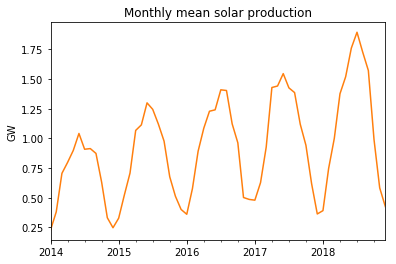

In [49]:
(df/1e3).resample('1M').mean().Solaire.plot(color='C1')
plt.title('Monthly mean solar production')
plt.ylabel('GW');

NB: last date is indeed Dec 31, 23:30.

In [41]:
df.Eolien.tail(3)


2018-12-31 22:30:00    1551.0
2018-12-31 23:00:00    1533.0
2018-12-31 23:30:00    1535.0
Name: Eolien, dtype: float64

### Compute capacity factor at each instant

In [42]:
wind_cf = (df.Eolien/inspow.P_wind).dropna()
solar_cf = (df.Solaire/inspow.P_sol).dropna()

In [46]:
wind_cf.head(2)

2014-01-01 00:00:00    0.425236
2014-01-01 00:30:00    0.411263
dtype: float64

In [47]:
wind_cf.tail(2)

2018-12-31 23:00:00    0.101469
2018-12-31 23:30:00    0.101602
dtype: float64

Check plot:

* we can see that the slow increasing trend has disappeared
* wind CF has more inter-year variability than solar 

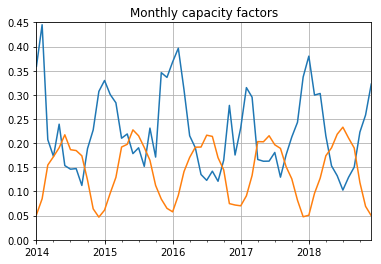

In [48]:
wind_cf.resample('1M').mean().plot()
solar_cf.resample('1M').mean().plot()
plt.ylim(0,0.45)
plt.title('Monthly capacity factors')
plt.grid()

Comparaison with RTE document [Panorama de l’électricité renouvelable](https://www.rte-france.com/fr/article/panorama-de-l-electricite-renouvelable), December 2018.

→ coherent

![Production éolienne (GWh) et facteur de charge mensuels (%), Panorama de l’Électricité Renouvelable en 2018 p16](img/wind_cf.png)
![Production solaire (GWh) et facteur de charge (%) mensuels, Panorama de l’Électricité Renouvelable en 2018, p24](img/solar_cf.png)

## Export file: load/wind cf/solar cf

In [50]:
lws = pd.DataFrame({'load': df.Consommation, 'wind_cf': wind_cf, 'solar_cf': solar_cf})
lws.head(3)

,load,wind_cf,solar_cf
2014-01-01 00:00:00,64660.0,0.425236,0.000000
2014-01-01 00:30:00,63494.0,0.411263,-0.000229
2014-01-01 01:00:00,61362.0,0.407951,-0.000229


Quick glimpse at the complementarity of wind and solar:

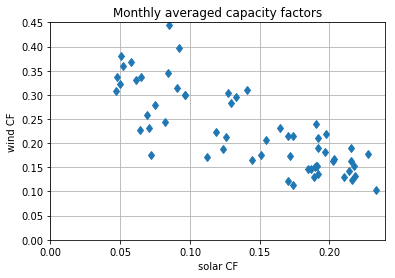

In [52]:
plt.plot(lws.resample('1M').mean().solar_cf, lws.resample('1M').mean().wind_cf, 'd')
ax = plt.gca()
ax.grid(True)
ax.set(
    title='Monthly averaged capacity factors',
    xlim=(0, 0.24),
    xlabel='solar CF',
    ylim=(0, 0.45),
    ylabel='wind CF'
);

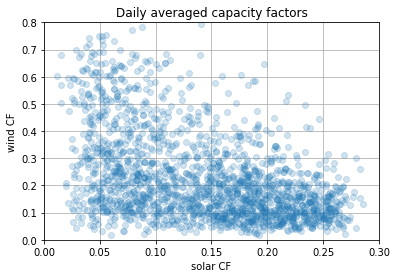

In [53]:
plt.plot(lws.resample('1D').mean().solar_cf, lws.resample('1D').mean().wind_cf, 'o', alpha=0.2)
ax = plt.gca()
ax.grid(True)
ax.set(
    title='Daily averaged capacity factors',
    xlim=(0, 0.3),
    xlabel='solar CF',
    ylim=(0, 0.8),
    ylabel='wind CF'
);

Write to CSV

In [54]:
lws.round(6).to_csv('load_wind_solar.csv')

In [55]:
!head load_wind_solar.csv

,load,wind_cf,solar_cf
2014-01-01 00:00:00,64660.0,0.425236,0.0
2014-01-01 00:30:00,63494.0,0.411263,-0.000229
2014-01-01 01:00:00,61362.0,0.407951,-0.000229
2014-01-01 01:30:00,61217.0,0.398757,-0.000229
2014-01-01 02:00:00,60748.0,0.397651,-0.000229
2014-01-01 02:30:00,60249.0,0.405122,-0.000229
2014-01-01 03:00:00,58061.0,0.400463,-0.000229
2014-01-01 03:30:00,56247.0,0.398009,-0.000229
2014-01-01 04:00:00,54475.0,0.410504,-0.000229


In [56]:
!ls -hl load_wind_solar.csv

-rw-r--r-- 1 pierre pierre 3,8M mars   7 12:07 load_wind_solar.csv


CSV file compression: 3.8 MB to 0.7 MB

In [57]:
!xz load_wind_solar.csv

In [58]:
!ls -hl load_wind_solar.csv.xz

-rw-r--r-- 1 pierre pierre 696K mars   7 12:07 load_wind_solar.csv.xz
